In [2]:
%matplotlib inline
%matplotlib notebook
import tqdm
import pandas as pd
from human_aware_rl.human.data_processing_utils import * 
from human_aware_rl.human.process_dataframes import *
from overcooked_ai_py.utils import save_pickle, load_pickle
import random
from collections import defaultdict
from tqdm import trange

## Reading in

## Human-AI data reading

### Question Data

#### Analysis

In [3]:
final_hai_question_data = pd.read_csv("data/human/anonymized/HAI_questiondata.csv")

In [4]:
gender_responses = list([gen.lower() for gen in final_hai_question_data['gender']])

In [5]:
print("Male", sum([a[:1] == "m" for a in gender_responses]), "Female", sum([a[:1] == "f" for a in gender_responses]), "out of", len(gender_responses))

Male 38 Female 19 out of 58


(20, 59)

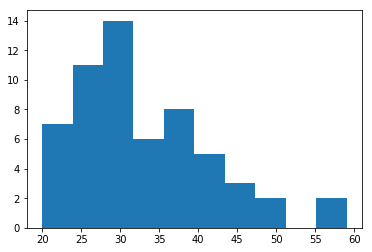

In [6]:
plt.hist([int(gen) for gen in final_hai_question_data['age']])
ages = [int(gen) for gen in final_hai_question_data['age']]
min(ages), max(ages)

### Game data

# Cleaning Trials
## Removing trials with low rewards

In [7]:
main_hai_trials = pd.read_pickle("data/human/anonymized/clean_human_AI_trials.pkl")

In [8]:
main_hai_trials

,action,cur_gameloop,datetime,indexOf,joint_action,layout,layout_name,model_type,next_state,player_index,...,score,state,template,time_elapsed,time_left,viewTime,reward_norm,cur_gameloop_total,reward_norm_total,workerid_num
482,NaN,0.0,1.558577e+12,NaN,"[[0, 0], [1, 0]]","[XXPXX, O 2O, X1 X, XDXSX]",cramped_room,pbt,"{'players': [{'position': [1, 2], 'orientation...",0,...,0.0,"{'players': [{'position': [1, 2], 'orientation...",NaN,2.062,58.0,NaN,0.0,393,0.0,11
483,NaN,1.0,1.558577e+12,NaN,"[[1, 0], INTERACT]","[XXPXX, O 2O, X1 X, XDXSX]",cramped_room,pbt,"{'players': [{'position': [2, 2], 'orientation...",0,...,0.0,"{'players': [{'position': [1, 2], 'orientation...",NaN,2.089,58.0,NaN,0.0,393,0.0,11
484,NaN,2.0,1.558577e+12,NaN,"[[0, 0], [-1, 0]]","[XXPXX, O 2O, X1 X, XDXSX]",cramped_room,pbt,"{'players': [{'position': [2, 2], 'orientation...",0,...,0.0,"{'players': [{'position': [2, 2], 'orientation...",NaN,2.121,58.0,NaN,0.0,393,0.0,11
485,NaN,3.0,1.558577e+12,NaN,"[[0, 0], [0, -1]]","[XXPXX, O 2O, X1 X, XDXSX]",cramped_room,pbt,"{'players': [{'position': [2, 2], 'orientation...",0,...,0.0,"{'players': [{'position': [2, 2], 'orientation...",NaN,2.273,58.0,NaN,0.0,393,0.0,11
486,NaN,4.0,1.558577e+12,NaN,"[[0, 0], INTERACT]","[XXPXX, O 2O, X1 X, XDXSX]",cramped_room,pbt,"{'players': [{'position': [2, 2], 'orientation...",0,...,0.0,"{'players': [{'position': [2, 2], 'orientation...",NaN,2.416,58.0,NaN,0.0,393,0.0,11
487,NaN,5.0,1.558577e+12,NaN,"[[-1, 0], [-1, 0]]","[XXPXX, O 2O, X1 X, XDXSX]",cramped_room,pbt,"{'players': [{'position': [1, 2], 'orientation...",0,...,0.0,"{'players': [{'position': [2, 2], 'orientation...",NaN,2.568,57.0,NaN,0.0,393,0.0,11
488,NaN,6.0,1.558577e+12,NaN,"[[0, 0], INTERACT]","[XXPXX, O 2O, X1 X, XDXSX]",cramped_room,pbt,"{'players': [{'position': [1, 2], 'orientation...",0,...,0.0,"{'players': [{'position': [1, 2], 'orientation...",NaN,2.717,57.0,NaN,0.0,393,0.0,11
489,NaN,7.0,1.558577e+12,NaN,"[[0, 0], [1, 0]]","[XXPXX, O 2O, X1 X, XDXSX]",cramped_room,pbt,"{'players': [{'position': [1, 2], 'orientation...",0,...,0.0,"{'players': [{'position': [1, 2], 'orientation...",NaN,2.865,57.0,NaN,0.0,393,0.0,11
490,NaN,8.0,1.558577e+12,NaN,"[[0, 0], [0, -1]]","[XXPXX, O 2O, X1 X, XDXSX]",cramped_room,pbt,"{'players': [{'position': [1, 2], 'orientation...",0,...,0.0,"{'players': [{'position': [1, 2], 'orientation...",NaN,3.025,57.0,NaN,0.0,393,0.0,11
491,NaN,9.0,1.558577e+12,NaN,"[[1, 0], INTERACT]","[XXPXX, O 2O, X1 X, XDXSX]",cramped_room,pbt,"{'players': [{'position': [2, 2], 'orientation...",0,...,0.0,"{'players': [{'position': [1, 2], 'orientation...",NaN,3.164,57.0,NaN,0.0,393,0.0,11


In [9]:
def clean_pbt(main_hai_trials, remove_adversarial, remove_suspicious):
    main_trials_pbt = main_hai_trials[main_hai_trials['model_type'] == 'pbt']
    
    worker_layout_pairs = [
        [18, 16, 18, 12, 16, 9, 18],
        ["cramped_room", "cramped_room", "asymmetric_advantages", "asymmetric_advantages", "coordination_ring", "random3", "random3"]
    ]

    for workerid_num, layout in zip(*worker_layout_pairs):
        main_trials_pbt = remove_worker_on_map(main_trials_pbt, workerid_num, layout)

    if remove_adversarial:
        worker_layout_pairs = [
            [11, 4, 12, 16, 18, 14, 12, 16],
            ["cramped_room", "cramped_room", "cramped_room", "asymmetric_advantages", "coordination_ring", "random0", "random3", "random3"]
        ]
        
        for workerid_num, layout in zip(*worker_layout_pairs):
            main_trials_pbt = remove_worker_on_map(main_trials_pbt, workerid_num, layout)

    if remove_suspicious:
        worker_layout_pairs = [
            [12, 2]
            ["asymmetric_advantages", "coordination_ring"]
        ]
        
        for workerid_num, layout in zip(*worker_layout_pairs):
            main_trials_pbt = remove_worker_on_map(main_trials_pbt, workerid_num, layout)
    
    return main_trials_pbt

def clean_ppo_sp(main_hai_trials, remove_adversarial, remove_suspicious):
    main_trials_ppo_sp = main_hai_trials[main_hai_trials['model_type'] == 'ppo_sp']

    for workerid_num in [56, 54, 46, 43]:
        main_trials_ppo_sp = remove_worker_on_map(main_trials_ppo_sp, workerid_num, "asymmetric_advantages")

    if remove_adversarial:
        
        for workerid_num in [54, 53, 43, 42]:
            main_trials_ppo_sp = remove_worker_on_map(main_trials_ppo_sp, workerid_num, "cramped_room")
        
        for workerid_num in [53, 43]:
            main_trials_ppo_sp = remove_worker_on_map(main_trials_ppo_sp, workerid_num, "coordination_ring")
        
        main_trials_ppo_sp = remove_worker_on_map(main_trials_ppo_sp, 53, "asymmetric_advantages")

    if remove_suspicious:
        main_trials_ppo_sp = remove_worker_on_map(main_trials_ppo_sp, 56, "cramped_room")
        main_trials_ppo_sp = remove_worker_on_map(main_trials_ppo_sp, 55, "random3")
    return main_trials_ppo_sp

def clean_ppo_bc(main_hai_trials, remove_adversarial, remove_suspicious):
    main_trials_ppo_bc = main_hai_trials[main_hai_trials['model_type'] == 'ppo_bc']

    # Remove broken
    for workerid_num in [22, 26, 24]:
        main_trials_ppo_bc = remove_worker(main_trials_ppo_bc, workerid_num)
        
    for layout in ["asymmetric_advantages", "coordination_ring"]:
        main_trials_ppo_bc = remove_worker_on_map(main_trials_ppo_bc, 29, layout) # No actions for large portion of trial

    # Remove adversarial
    if remove_adversarial:
        for workerid_num in [32, 25]:
            main_trials_ppo_bc = remove_worker_on_map(main_trials_ppo_bc, workerid_num, "cramped_room")
        
        for workerid_num in [25, 37, 28, 23]:
            main_trials_ppo_bc = remove_worker_on_map(main_trials_ppo_bc, workerid_num, "coordination_ring")
        
        for workerid_num in [37, 28]:
            main_trials_ppo_bc = remove_worker_on_map(main_trials_ppo_bc, workerid_num, "asymmetric_advantages")

        for workerid_num in [28, 23, 35]:
            main_trials_ppo_bc = remove_worker_on_map(main_trials_ppo_bc, workerid_num, "random3")
        
    if remove_suspicious:
        main_trials_ppo_bc = remove_worker_on_map(main_trials_ppo_bc, 34, "asymmetric_advantages")
        
        for workerid_num in [34, 32, 19]:
            main_trials_ppo_bc = remove_worker_on_map(main_trials_ppo_bc, workerid_num, "coordination_ring")
            
    return main_trials_ppo_bc

In [10]:
data = defaultdict(dict)

In [11]:
remove_suspicious = False

In [12]:
for remove_adversarial, suffix in zip([False, True], ["_base", "_no_advers"]):
    print("ppo_sp")
    main_trials_ppo_sp = clean_ppo_sp(main_hai_trials, remove_adversarial, remove_suspicious)
    add_means_and_stds_from_df(data, main_trials_ppo_sp, "ppo_sp" + suffix)
    
    print("ppo_bc")
    main_trials_ppo_bc = clean_ppo_bc(main_hai_trials, remove_adversarial, remove_suspicious)
    add_means_and_stds_from_df(data, main_trials_ppo_bc, "ppo_bc" + suffix)
    
    print("pbt")
    main_trials_pbt = clean_pbt(main_hai_trials, remove_adversarial, remove_suspicious)
    add_means_and_stds_from_df(data, main_trials_pbt, "pbt" + suffix)
    
    if remove_adversarial is True:
        clean_humanai = pd.concat([main_trials_pbt, main_trials_ppo_bc, main_trials_ppo_sp])
        clean_humanai.to_pickle("data/human/anonymized/filtered_humanai_trials.pkl")

ppo_sp
ppo_bc
pbt
ppo_sp
ppo_bc
pbt


In [9]:
data

defaultdict(dict,
            {'asymmetric_advantages': {'ppo_sp_base_0': (115.0,
               12.119199643540822),
              'ppo_sp_base_1': (132.5, 21.19478119726646),
              'ppo_bc_base_0': (84.44444444444444, 13.976268343787561),
              'ppo_bc_base_1': (150.0, 30.092450142112984),
              'pbt_base_0': (93.33333333333333, 15.07184440694504),
              'pbt_base_1': (134.28571428571428, 25.782223179353068),
              'ppo_sp_no_advers_0': (115.0, 12.119199643540822),
              'ppo_sp_no_advers_1': (151.42857142857142, 13.313882800244972),
              'ppo_bc_no_advers_0': (95.0, 11.039701082909808),
              'ppo_bc_no_advers_1': (180.0, 14.966629547095765),
              'pbt_no_advers_0': (93.33333333333333, 15.07184440694504),
              'pbt_no_advers_1': (156.66666666666666, 17.898892992874462)},
             'coordination_ring': {'ppo_sp_base_0': (85.45454545454545,
               11.808642049250745),
              'ppo_sp_ba

In [10]:
# Convert layout names to python format
data_copy = data.copy()
for k, v in data_copy.items():
    if k != JS_LAYOUT_NAME_TO_PYTHON_NAME[k]:
        data[JS_LAYOUT_NAME_TO_PYTHON_NAME[k]] = v
        del data[k]

In [14]:
save_pickle(data, "data/human/anonymized/humanai_performance")

## Exporting data for stats

In [15]:
rew_per_round = clean_humanai.groupby(["layout_name", "workerid_num"])["reward_norm_total"].mean().reset_index()
performance_per_round_with_type_df = final_hai_question_data.set_index('workerid_num').join(rew_per_round.set_index('workerid_num')).reset_index()
performance_per_round_with_type_df.head()

,workerid_num,Unnamed: 0,MODEL_TYPE,PLAYER_INDEX,age,bonus_calc,bot_test,difficulty,early_exit,fun,gender,intuitiveness,other_feedback,partner_strategy,self_strategy,smoothness,video_games,layout_name,reward_norm_total
0,0,57,pbt,1,26,0.7,I listen to all types of music but mostly list...,1,False,3,male,6,NaN,I would describe my partners strategy as gener...,I would describe my strategy as always trying ...,1,My experience playing video games is moderate.,asymmetric_advantages,100.0
1,0,57,pbt,1,26,0.7,I listen to all types of music but mostly list...,1,False,3,male,6,NaN,I would describe my partners strategy as gener...,I would describe my strategy as always trying ...,1,My experience playing video games is moderate.,coordination_ring,100.0
2,0,57,pbt,1,26,0.7,I listen to all types of music but mostly list...,1,False,3,male,6,NaN,I would describe my partners strategy as gener...,I would describe my strategy as always trying ...,1,My experience playing video games is moderate.,cramped_room,80.0
3,0,57,pbt,1,26,0.7,I listen to all types of music but mostly list...,1,False,3,male,6,NaN,I would describe my partners strategy as gener...,I would describe my strategy as always trying ...,1,My experience playing video games is moderate.,random0,0.0
4,0,57,pbt,1,26,0.7,I listen to all types of music but mostly list...,1,False,3,male,6,NaN,I would describe my partners strategy as gener...,I would describe my strategy as always trying ...,1,My experience playing video games is moderate.,random3,0.0


In [16]:
performance_per_round_with_type_df = performance_per_round_with_type_df.rename(columns={"reward_norm_total": "reward"})
performance_per_round_with_type_df = performance_per_round_with_type_df.dropna(subset=['reward'])
performance_per_round_with_type_df = performance_per_round_with_type_df.astype({'reward': 'int32'})
performance_per_round_with_type_df.to_csv("data/human/anonymized/human_ai_exp_data_with_advers.csv")

## Visualizations

In [17]:
ppo_sp_trials = main_hai_trials[main_hai_trials['model_type'] == 'ppo_sp']

In [18]:
scenario_rews, worker_rews = get_trials_scenario_and_worker_rews(ppo_sp_trials)

In [19]:
get_dict_stats(scenario_rews)

{'cramped_room': {'mean': 77.0,
  'standard_error': 9.515776374001229,
  'max': 140.0,
  'n': 20},
 'asymmetric_advantages': {'mean': 102.0,
  'standard_error': 13.992855319769442,
  'max': 200.0,
  'n': 20},
 'coordination_ring': {'mean': 77.0,
  'standard_error': 8.749285685128815,
  'max': 160.0,
  'n': 20},
 'random3': {'mean': 51.0,
  'standard_error': 7.807048097712732,
  'max': 100.0,
  'n': 20},
 'random0': {'mean': 44.0,
  'standard_error': 13.16054710108968,
  'max': 200.0,
  'n': 20}}

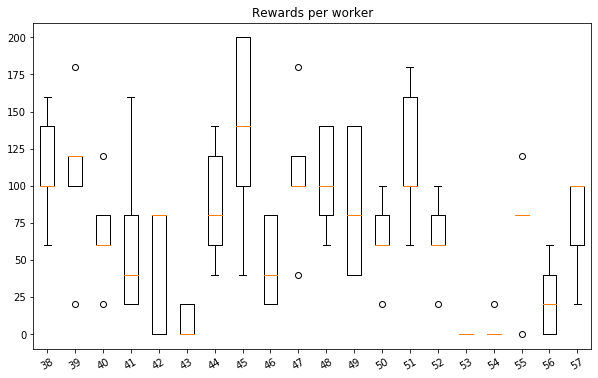

In [20]:
plt.figure(figsize=(10, 6))
plt.title("Rewards per worker")
plt.boxplot(list(worker_rews.values()), labels=list(worker_rews.keys()))
plt.xticks(rotation=30)
plt.show()

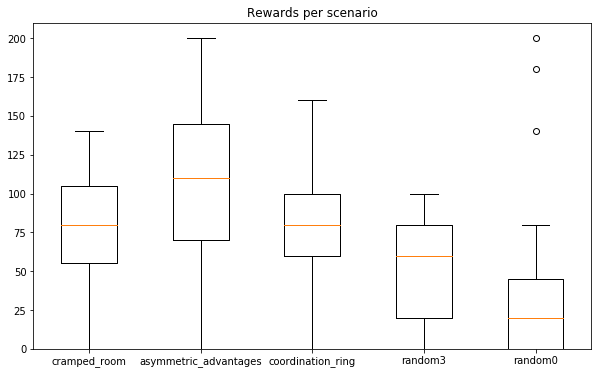

In [21]:
plt.figure(figsize=(10, 6))
plt.title("Rewards per scenario")
plt.boxplot(list(scenario_rews.values()), labels=list(scenario_rews.keys()))
plt.ylim(0,)
plt.show()

To make the following work, install ipywidgets (conda installation recommended, https://ipywidgets.readthedocs.io/en/stable/user_install.html)

In [22]:
display_interactive_by_layout(clean_humanai, 'random0', limit=3)

X X X P X 
O   X ↑0P 
O ↑1X   X 
D   X   X 
X X X S X 

Joint Action: ('stay', 'stay') 	 Score: 0


Output()

IntSlider(value=0, max=403)

In [27]:
display_interactive_by_workerid(clean_humanai, 10)

X X X P X 
O   X ↑0P 
O ↑1X   X 
D   X   X 
X X X S X 

Joint Action: ('stay', 'stay') 	 Score: 0


Output()

IntSlider(value=0, max=403)